In [60]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib

import importlib
from pathlib import Path

import sys

import cProfile, pstats

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [3]:
img  = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/REDIM_diravg.nii.gz")
mask = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/B0_WMPARC.nii.gz")

signal = np.flip(img.get_fdata(), axis = 0) # flip it such that it matches the indices in MRView
seg = np.flip(mask.get_fdata(), axis = 0)

print(signal.shape)

(96, 96, 54, 30)


In [4]:
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/bvals.txt") / 1000 # in unit ms/{\mu m} ^2
TEs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/TEs.txt")/1000  # in unit s
qs = np.column_stack((bvals, TEs))

In [5]:
signal_norm = signal[:,:,:,qs[:,0]!=0] / np.repeat(signal[:,:,:,qs[:,0]==0], 5, axis = -1)
qs_norm = np.delete(qs, qs[:, 0] == 0, axis = 0)

In [96]:
Sqs = signal_norm[30:40, 65, 15:25, :].reshape((-1, qs_norm.shape[0]), order = 'C')

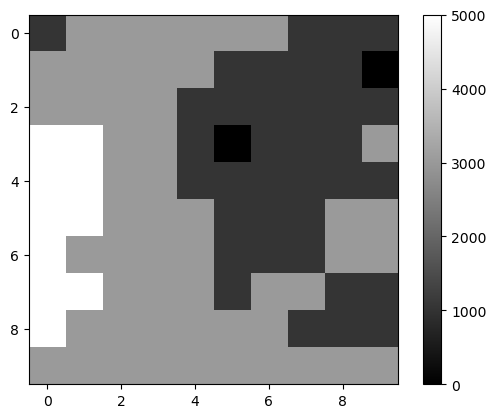

In [97]:
plt.imshow(np.fliplr(np.rot90(seg[30:40, 65, 15:25])), cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()


In [98]:
theta1 = np.linspace(0.001, 3, 100)
theta2 = np.linspace(0.01, 40, 100)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_plane_2D(10, 10, 25, order = 2)

In [99]:
std_vector = 0.02*np.ones(len(Sqs))
sigma = np.repeat(std_vector, 25)

for i in range(1):
    _, f_est, _ = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                            R_csr = sp.csr_matrix(R.shape), f0 = None, normalize = True,
                            Lambdas = None, rho = 1, rho_ratio = 3, dynamic_rho = True, 
                            beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 5,
                            cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                            admm_tol = 1e-10, admm_maxiter = 100)

    Sqs_est = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_est)

    diff = Sqs - Sqs_est
    std_vector = np.std(diff, axis = 1)
    sigma = np.repeat(std_vector, 25)


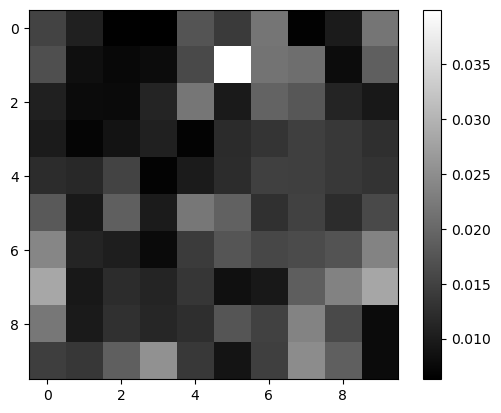

In [100]:
plt.imshow(np.fliplr(np.rot90(std_vector.reshape((10, 10)))), cmap = 'gray')
plt.colorbar()


In [101]:
# sigma[sigma <= 0.01] = 0.01
print("Mean of sigma is:", np.mean(sigma))

Mean of sigma is: 0.014396096467298275


In [102]:
lambdas, f_hat, obj_history = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                                        R_csr = R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 1, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-4, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 100)

7.678804205143754e-11 4.802874886468404e-11



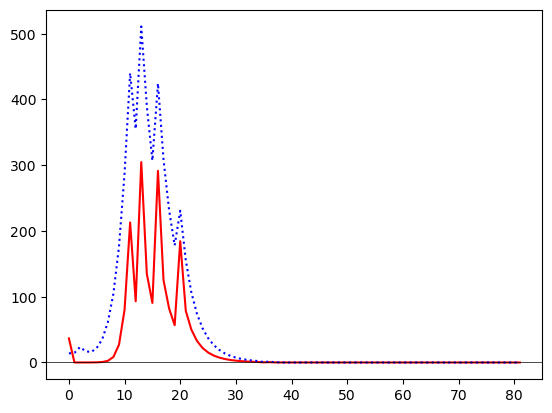

In [103]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
print(obj_history[1][-1], obj_history[2][-1])
print()

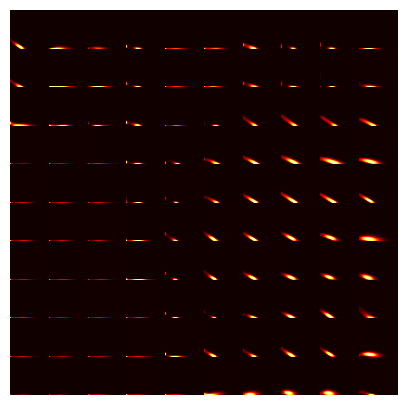

In [105]:
# the rows is the rows of image in the MRView, the cols is the cols.
# Since the cols in the image is the first dimension in the signal,
# So, the signal is in dimension 56*57, and the plots are in 57*56

rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, figsize=(5, 5)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for j in range(cols):
    for i in range(rows):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, f_hat[rows*(cols - 1 - j)+(rows - 1 - i)].reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        # ax.text(0.02, 0.02, f'{15*(14 - i)+(14 - j)}', color='white', fontsize=8,
        #         transform=ax.transAxes, ha='left', va='bottom')
        ax.axis("off")
plt.show()

In [106]:
Sqs_recovered = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_hat)
std_recovered = np.std(Sqs - Sqs_recovered, axis = 1)
print(np.mean(std_recovered))

0.014119388432829665


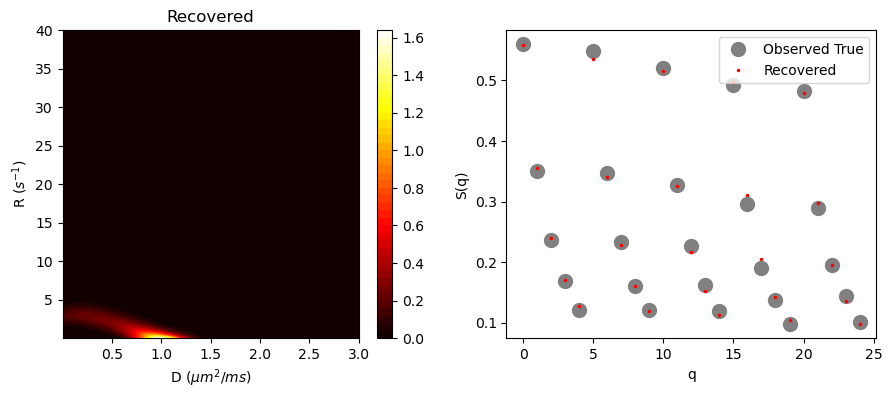

In [107]:
bf.contourf_compare(theta1, theta2, f_hat = f_hat[0].ravel(), qs = qs_norm, Sqs = Sqs[0].ravel(), f_true = None, savepath = None)

# Compare

In [18]:
import torch
hpc = torch.load("/Users/xunan/Downloads/run_checkpoint.pt", map_location="cpu")
print(type(hpc))
print(hpc.keys() if isinstance(hpc, dict) else hpc.shape)

<class 'dict'>
dict_keys(['lambdas', 'f_hat', 'obj_history'])


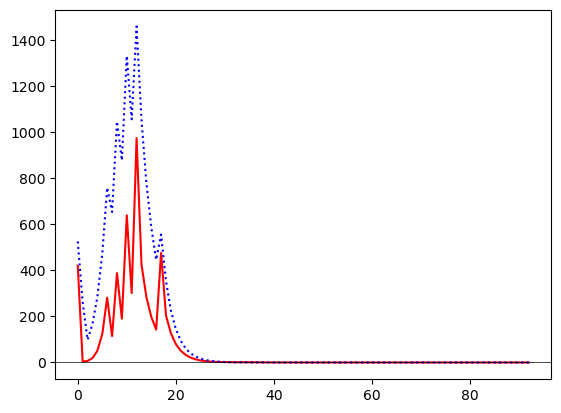

In [ ]:
plt.plot(hpc['obj_history'][1][:], '-', color = 'red', label = 'primal')
plt.plot(hpc['obj_history'][2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)



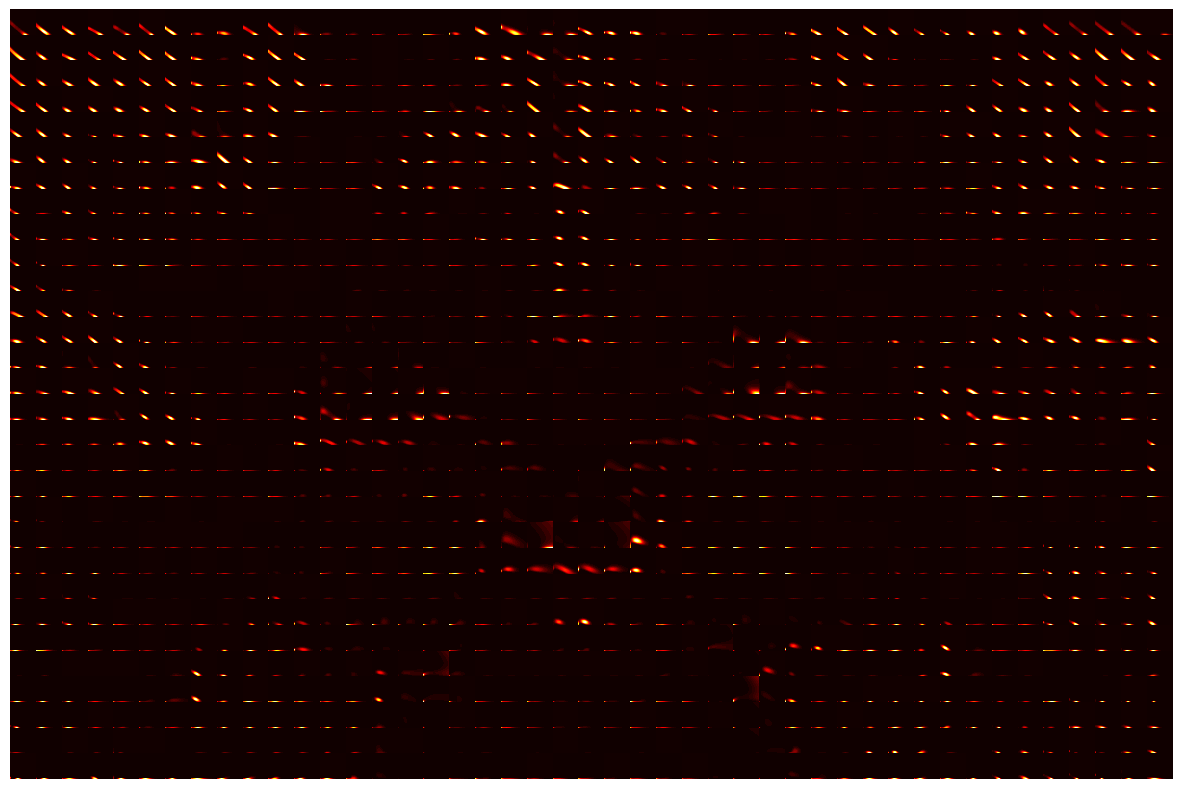

In [21]:
rows = 30
cols = 45
fig, axs = plt.subplots(rows, cols, figsize=(15, 10)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for j in range(cols):
    for i in range(rows):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, hpc['f_hat'][rows*(cols - 1 - j)+(rows - 1 - i)].numpy().reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        # ax.text(0.02, 0.02, f'{15*(14 - i)+(14 - j)}', color='white', fontsize=8,
        #         transform=ax.transAxes, ha='left', va='bottom')
        ax.axis("off")

In [22]:
Sqs_recovered = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, hpc['f_hat'].numpy())

std_recovered = np.std(Sqs - Sqs_recovered, axis = 1)
print("Mean of sigma", np.mean(std_recovered))

Mean of sigma 0.016462677513218133


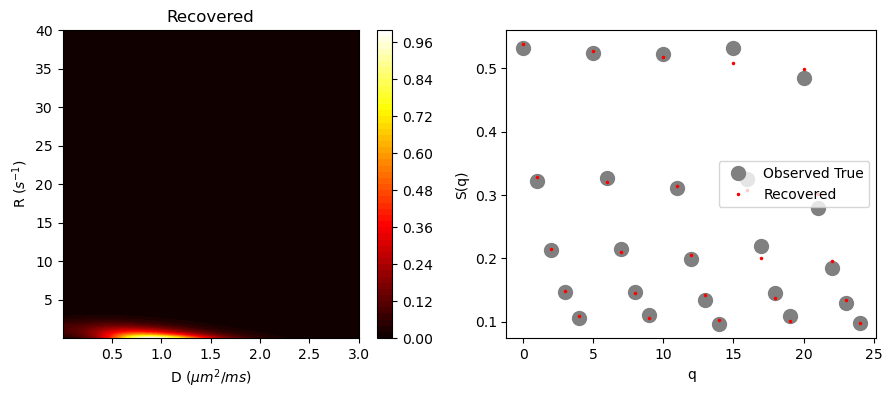

In [23]:
bf.contourf_compare(theta1, theta2, f_hat = hpc['f_hat'][0].numpy().ravel(), qs = qs_norm, Sqs = Sqs[0].ravel(), f_true = None, savepath = None)

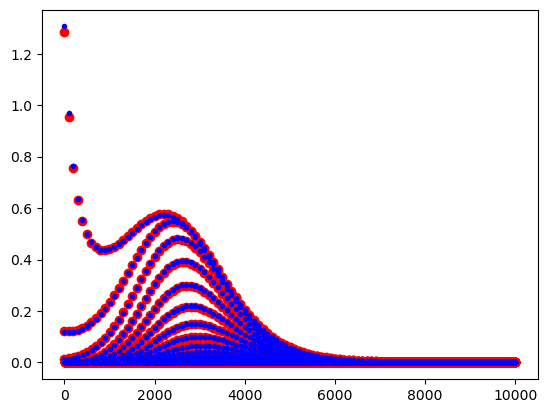

In [24]:
plt.plot(hpc['f_hat'][45].numpy().T[:], 'o', color = 'red')
plt.plot(f_hat[45].T[:], '.', color = 'blue')

In [4]:
rr.R_cube_2D(2, 2, 2, 1, 1).todense()

matrix([[ 6., -2., -2.,  0., -2.,  0.,  0.,  0.],
        [-2.,  6.,  0., -2.,  0., -2.,  0.,  0.],
        [-2.,  0.,  6., -2.,  0.,  0., -2.,  0.],
        [ 0., -2., -2.,  6.,  0.,  0.,  0., -2.],
        [-2.,  0.,  0.,  0.,  6., -2., -2.,  0.],
        [ 0., -2.,  0.,  0., -2.,  6.,  0., -2.],
        [ 0.,  0., -2.,  0., -2.,  0.,  6., -2.],
        [ 0.,  0.,  0., -2.,  0., -2., -2.,  6.]])

# Cube

In [95]:
Sqs = signal_norm[30:34, 30:35, 30:36, :].reshape((-1, qs_norm.shape[0]), order = 'C')
R = rr.R_cube_2D(4, 5, 6, 5, 5, order = 1)

In [96]:
lambdas, f_hat, obj_history = das.admm( qs_norm, thetas, weights, Sqs, sigma = 0.02,
                                        R_csr = 100000*R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 1, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 100)

In [97]:
f_reshaped = f_hat.reshape((4, 5, 6, -1), order = 'C')

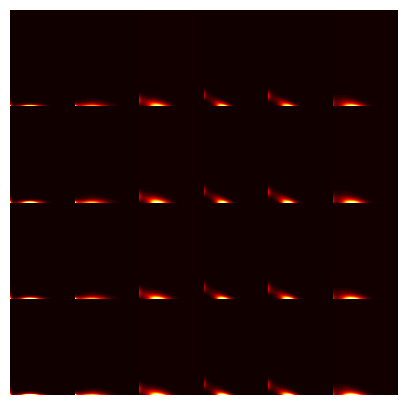

In [99]:
rows = 4
cols = 6
fig, axs = plt.subplots(rows, cols, figsize=(5, 5)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for i in range(4):
    for j in range(6):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, f_reshaped[i, 0, j, :].reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        # ax.text(0.02, 0.02, f'{15*(14 - i)+(14 - j)}', color='white', fontsize=8,
        #         transform=ax.transAxes, ha='left', va='bottom')
        ax.axis("off")
plt.show()